In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
%load_ext rpy2.ipython

#### Load the data
We load the preprocessed, trial data aligned to the response time. Trials are 4 seconds.

In [31]:
behavior = load_behavioral_data(min_RT = 0.2)

Include the distance from indifference for each subject. 

In [32]:
%%R -i behavior -o dist_indiff
library(lme4)
library(lmerTest)

# for each subject, run acccept ~ gain + loss
# and save the coefficients
# CHANGE THIS TO MAKE IT MORE INTERPRETABLE
slope <- c()
subs <- c()
for (i in unique(behavior$sub)) {
    sub_behavior = behavior[behavior$sub == i,]
    model = glm(accept ~ gain + loss, data = sub_behavior, family=binomial)
    slope <- c(slope, unname(coef(model)["loss"]) / unname(coef(model)["gain"]))
    subs <- c(subs, i)
}

dist_indiff <- data.frame(sub = subs, slope = slope)

In addition: There were 14 warnings (use warnings() to see them)


In [33]:
behavior = behavior.merge(dist_indiff, on = "sub")

In [34]:
behavior["dist_from_indiff"] = np.abs((behavior["gain"] + behavior["slope"] * behavior["loss"]) / np.sqrt(1 + behavior["slope"]**2))
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])

In [54]:
# TODO: CHECK RANGE OF DIST_FROM_INDIFF

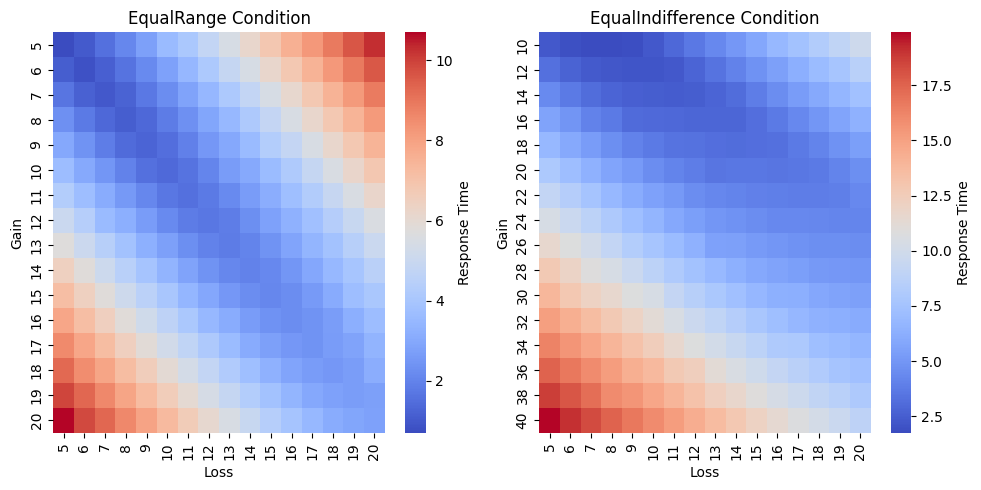

In [51]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['dist_from_indiff'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("EqualRange Condition")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['dist_from_indiff'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("EqualIndifference Condition")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

<Axes: xlabel='slope'>

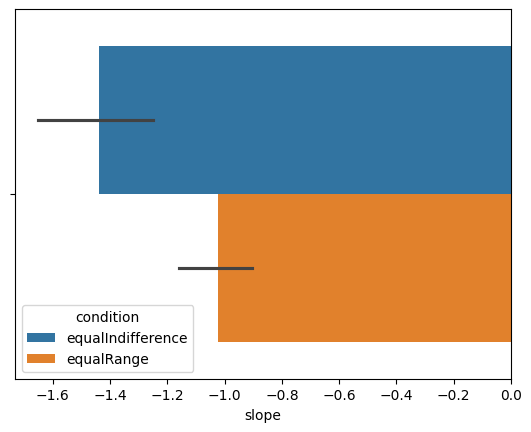

In [52]:
sns.barplot(data.groupby(["condition", "sub"])["slope"].mean().reset_index(), x = "slope", hue = "condition")

### Average every 0.5 seconds pupil

In [ ]:
timebins = np.arange(0, 4, 0.5)
pupil_response = []
for timebin in timebins:
    # TODO: Check the groupby because estimates for loss and gain estimates are different
    decision_pupil = data.query(f"timebin > {timebin} & timebin < {timebin + 0.5}").groupby(["sub", "condition", "gain", "loss", "accept", "dist_from_indiff", "RT"])[["ps_preprocessed", "blink"]].mean().reset_index()
    decision_pupil["timebin"] = timebin
    pupil_response.append(decision_pupil)
pupil_response = pd.concat(pupil_response)

#### Modeling timebins of pupil size
We will model the pupil size as a function of the accept, blink, and condition. We want to observe the effect of the accept, gain, and loss on pupil size. Furthermore, we want to eliminate the effect of blink and condition

In [44]:
%%R -i pupil_response
library(mgcv)
library(lme4)
library(lmerTest)

/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [55]:
# TODO: Just look dist_from_indiff, and then look at just gain, loss
# This is to make sure that the estimates are not too different 

,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial,slope,dist_from_indiff
0,1,1,equalIndifference,14,6,2.388,1,3.0,weakly_accept,1,-0.937114,6.112738
1,1,1,equalIndifference,34,14,2.289,1,4.0,strongly_accept,2,-0.937114,15.235958
2,1,1,equalIndifference,34,13,1.873,1,4.0,strongly_accept,3,-0.937114,15.919750
3,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,4,-0.937114,0.458862
4,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,5,-0.937114,4.235905
...,...,...,...,...,...,...,...,...,...,...,...,...
27438,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,252,-1.081704,5.528305
27439,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,253,-1.081704,3.214495
27440,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,254,-1.081704,7.620262
27441,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,255,-1.081704,5.071328


In [56]:
%%R
# loop through timebins
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
condition_list <- c()
for (tb in unique(pupil_response$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model_indiff = lmer(ps_preprocessed ~ dist_from_indiff + blink + (1 | sub), data=pupil_response[pupil_response$timebin == tb & pupil_response$condition == 'equalIndifference', ])
    model_equal = lmer(ps_preprocessed ~ dist_from_indiff + blink + (1 | sub), data=pupil_response[pupil_response$timebin == tb & pupil_response$condition == 'equalRange', ])
    # save the coefficients and pvalues in a list
    fixed_effects <- summary(model_indiff)$coefficients
    # Loop through fixed effects
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
        condition_list <- c(condition_list, 'equalIndifference')
    }

    fixed_effects <- summary(model_equal)$coefficients
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
        condition_list <- c(condition_list, 'equalRange')
    }
}

In [57]:
%%R -o all_sub_pupil_coef
# put them into a dataframe
all_sub_pupil_coef <- data.frame(timebin = timebins, 
                            name = coefficient_name, 
                            estimate = coefficient_estimate, 
                            pvalue = coefficient_pvalues, 
                            condition = condition_list)

In [58]:
equalRange_rows = all_sub_pupil_coef["condition"] == 'equalRange'
equalIndifference_rows = all_sub_pupil_coef["condition"] == 'equalIndifference'

all_sub_pupil_coef["pvalue"] = stats.false_discovery_control(all_sub_pupil_coef['pvalue'].values, method = "by")

In [59]:
timebins = all_sub_pupil_coef['timebin'].unique()
names = ["dist_from_indiff"]

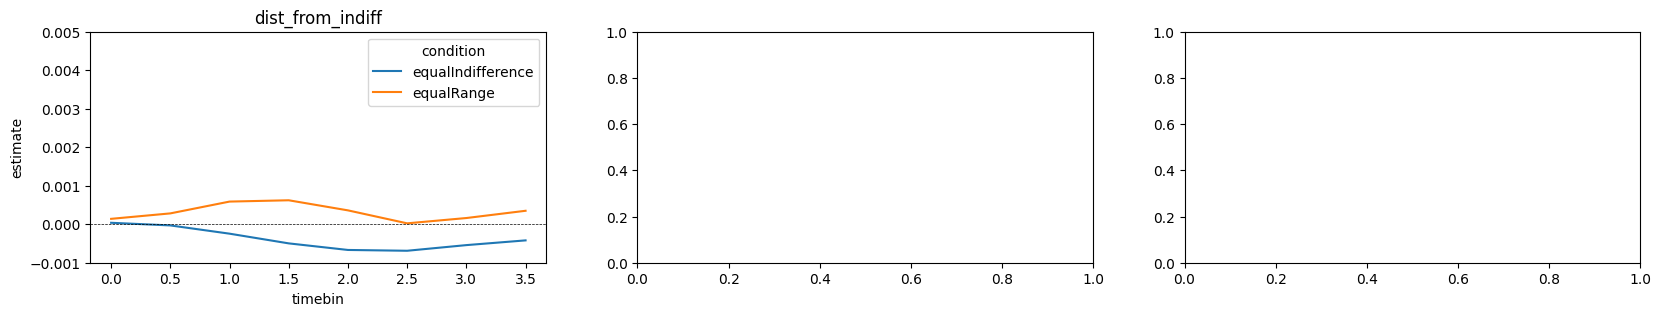

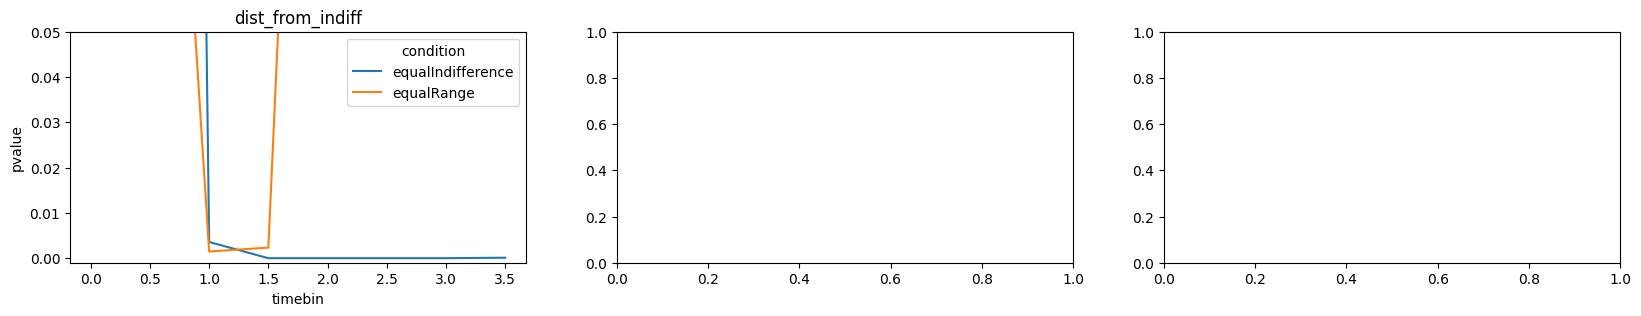

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for name, ax in zip(names, axs.flatten()):
    sns.lineplot(data=all_sub_pupil_coef.query(f"name == '{name}'"), x='timebin', y='estimate', hue = 'condition', ax=ax)
    # add a horizontal line at 0
    ax.axhline(0, ls="--", c="k", lw=0.5)
    ax.set_title(name)
    ax.set_ylim(-0.001, 0.005)

fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for name, ax in zip(names, axs.flatten()):
    sns.lineplot(data=all_sub_pupil_coef.query(f"name == '{name}'"), x='timebin', y='pvalue', hue = 'condition', ax=ax)
    ax.set_title(name)
    ax.set_ylim(-0.001, 0.05)

Could be a bias to group average that is making the initial model better (when individual estimates are added, you introduce more variance)